# Gráficas para Bogotá

In [1]:
import pandas as pd
import os
from pathlib import Path
import numpy as np
import seaborn as sns
from datetime import date
from datetime import datetime
import matplotlib.pyplot as plt
from adjustText import adjust_text
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter, FixedLocator, MultipleLocator
import locale
plt.style.use('Solarize_Light2')
locale.setlocale(locale.LC_TIME, 'es_ES.UTF-8');

## Dataset
Los datos se toman de la página de datos abiertos de salud de Bogotá
El instituto encargado de recopilar la información es Saludata

In [2]:
url2 = 'http://saludata.saludcapital.gov.co/osb/datos_abiertos_osb/enf-transmisibles/OSB_EnfTransm-COVID-19.csv'
bog = pd.read_csv(url2,encoding='iso-8859-1', sep=';', skiprows=4,skipfooter=2, parse_dates=['Fecha de diagnóstico'], dayfirst=True)

In [3]:
bog.tail(3)

,ID de caso,Fecha de diagnóstico,Ciudad de residencia,Localidad de residencia,Edad,Sexo,Tipo de caso,Ubicación,Estado
55053,55054,2020-04-08,Bogotá,Barrios Unidos,61,M,En estudio,Fallecido,Fallecido
55054,55055,2020-07-15,Sin Dato,Sin Dato,91,F,En estudio,Casa,Leve
55055,55056,2020-07-15,Sin Dato,Sin Dato,18,F,En estudio,Casa,Leve


In [4]:
bog_casos = bog.groupby(['Fecha de diagnóstico','Localidad de residencia'])['ID de caso'].count().unstack().fillna(0)
bog_casos_acu = bog_casos.cumsum()

In [5]:
def rollingCases(df, cases, cantidad):
    df_append = pd.DataFrame()
    df = df.rolling(7, min_periods=1, win_type='gaussian').mean(std=2)
    df.reset_index(drop=True, inplace=True)
    df =  df.reindex( columns=df.tail(7).mean().sort_values(ascending=False).index)
    #df = df.sort_values(axis=1, by=df.index[-7:-1].mean(), ascending=False).reset_index(drop=True)
    for ciudad in range(cantidad):
        df_temp = pd.DataFrame()
        # Se toma el indice desde que los casos superan X cantidad
        first_value = df[ df.iloc[:,ciudad] >= cases ].iloc[:,ciudad].head(1)
        if not first_value.empty:
            idx = first_value.index[0]
            df_temp['datos'] = df.iloc[idx:,ciudad]
            df_temp['ciudad'] = df.columns[ciudad]
            df_temp.reset_index(inplace=True)
            df_append = pd.concat([df_append, df_temp])
    return df_append

In [6]:
sns.set()
def graficar(df,titulo,xlabel,ylabel,texto):
    text = []
    ciudades = df['ciudad'].unique()
    #plt.style.use('fivethirtyeight')
    #plt.style.use('ggplot')
    plt.style.use('Solarize_Light2')
    plt.figure(figsize=(16,9), dpi=500)
    plt.margins(0.005,0.05)
    for ciudad in ciudades:
        if not ciudad == 'Sin Dato':
            y = df[df['ciudad']==ciudad]['datos']
            fig = sns.lineplot(x = y.index, y = y, data = df, legend=False)  
            if ciudad == 'Bogotá D.C.':
                ciudad = 'Bogotá'
            elif ciudad == 'San Andrés de Tumaco':
                ciudad = 'Tumaco'
            elif ciudad == 'Cartagena de Indias':
                ciudad = 'Cartagena'
            if ciudad == 'SIERRA NEVADA-PERIJÁ-ZONA BANANERA':
                pos = (-250,3)
            else:
                pos = (5,1)
            size = 16
            fig.annotate(ciudad, 
                xy=(y.index[-1], y.iloc[-1]), 
                xytext=pos, 
                color= plt.gca().lines[-1].get_color() ,  
                textcoords="offset points",
                size=size, va="center",weight='bold')
        #adjust_text(text)   
    ax = plt.gca()
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.yaxis.set_major_locator(FixedLocator([1,3,5,10,30,50,100,300,500,1000,3000,5000,10000,30000,50000,100000,300000,500000,1000000]))
    ax.xaxis.set_major_locator(MultipleLocator(10))
    plt.xlabel(xlabel, fontsize=18, weight='bold')
    plt.ylabel(ylabel, fontsize=16, weight='bold')
    plt.title(titulo, fontsize=18, weight='bold')
    plt.gcf().text(0.55, 0.15, texto, fontsize=10)
    plt.savefig(f'{carpeta}{titulo}.png', facecolor='w', bbox_inches='tight')
    plt.show()

In [7]:
num_casos_acu = 100
num_casos_diarios = 30
localidades = 10

In [8]:
fecha = date.today()
fecha_cool = datetime.strftime(fecha,'%B %d')
fecha = str(fecha)
texto_col = f'Instituto Nacional de Salud - @JairoTorregrose - {fecha_cool}'
texto_bog = f'SALUDATA - @JairoTorregrose - {fecha_cool}'
carpeta = f'maps/{fecha}/'
Path(carpeta).mkdir(parents=True, exist_ok=True)

In [9]:
titulo_diarios = f'TOP {localidades} localidades en Bogotá con Casos Diarios'
xlabel_diarios = f'Número de días desde los primeros {num_casos_diarios} casos diarios'
ylabel_diarios = 'Casos diarios'

titulo_acu = f'TOP {localidades} localidades en Bogotá con Casos Acumulados'
xlabel_acu = f'Número de días desde los primeros {num_casos_acu} casos'
ylabel_acu = 'Casos acumulados'

In [10]:
df_bog_casos = rollingCases(bog_casos, cases=num_casos_diarios, cantidad=localidades)
df_bog_casos_acu = rollingCases(bog_casos_acu, cases=num_casos_acu, cantidad=localidades)

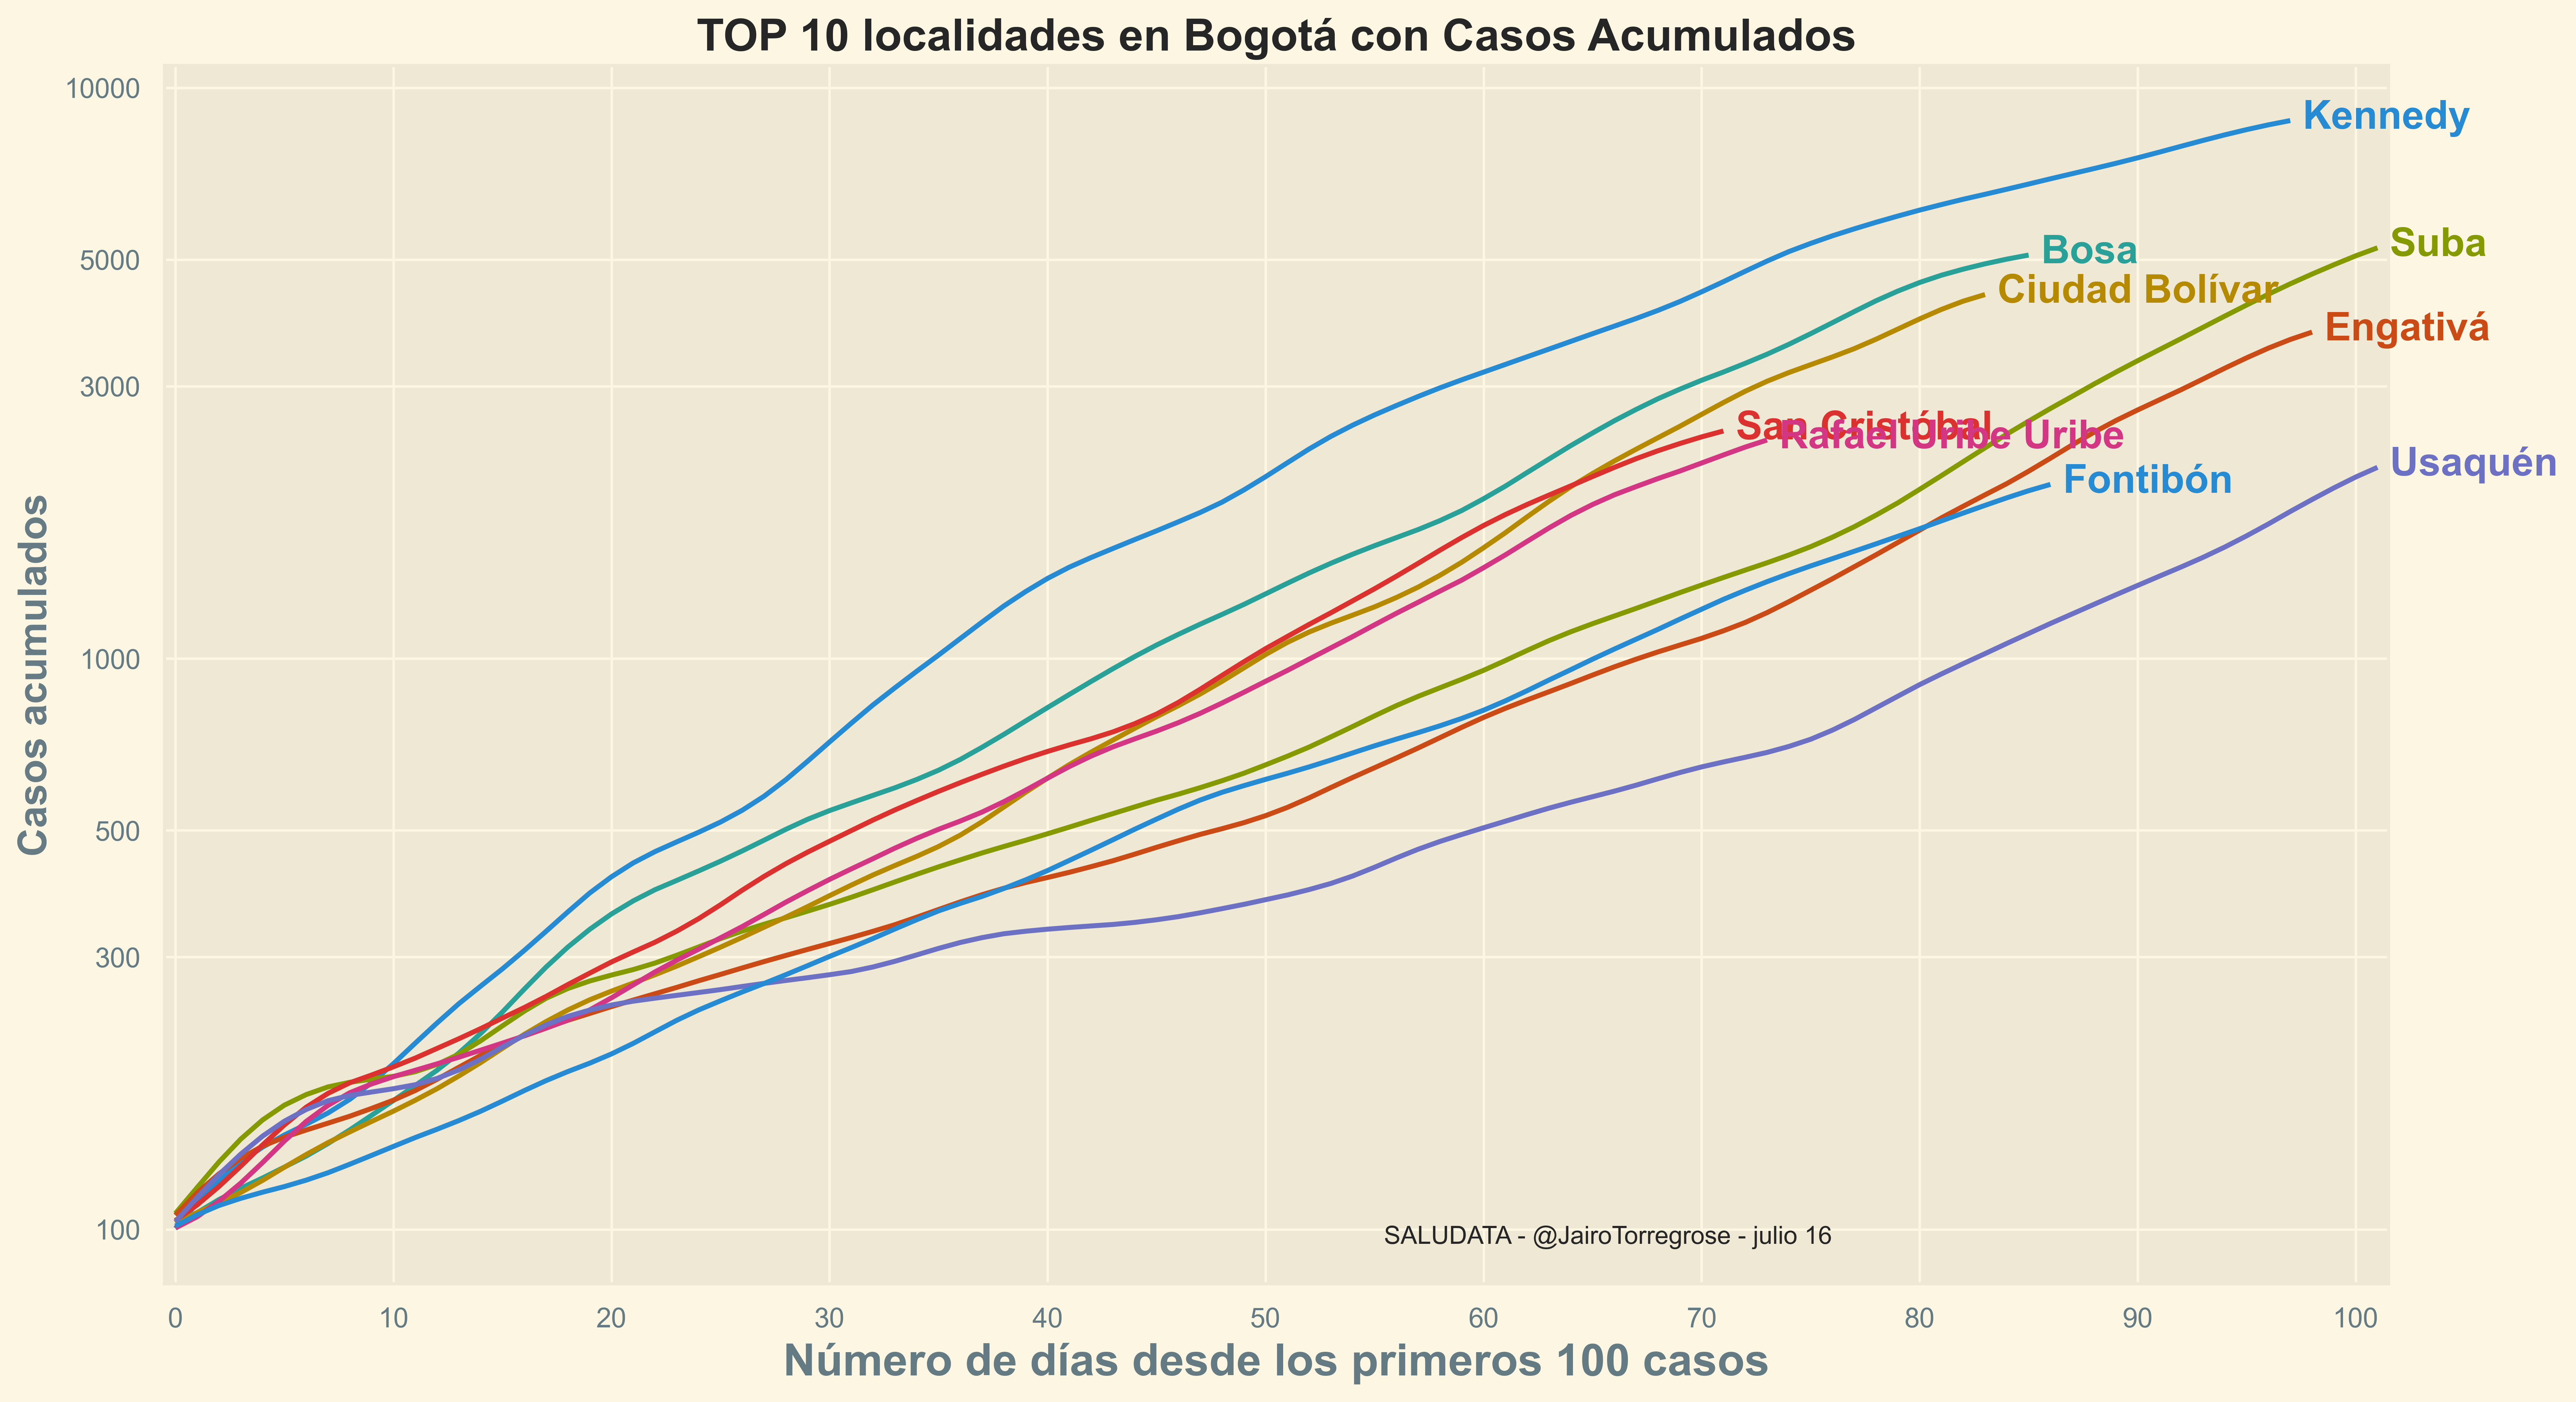

In [11]:
graficar(df_bog_casos_acu, titulo_acu, xlabel_acu, ylabel_acu ,texto_bog)

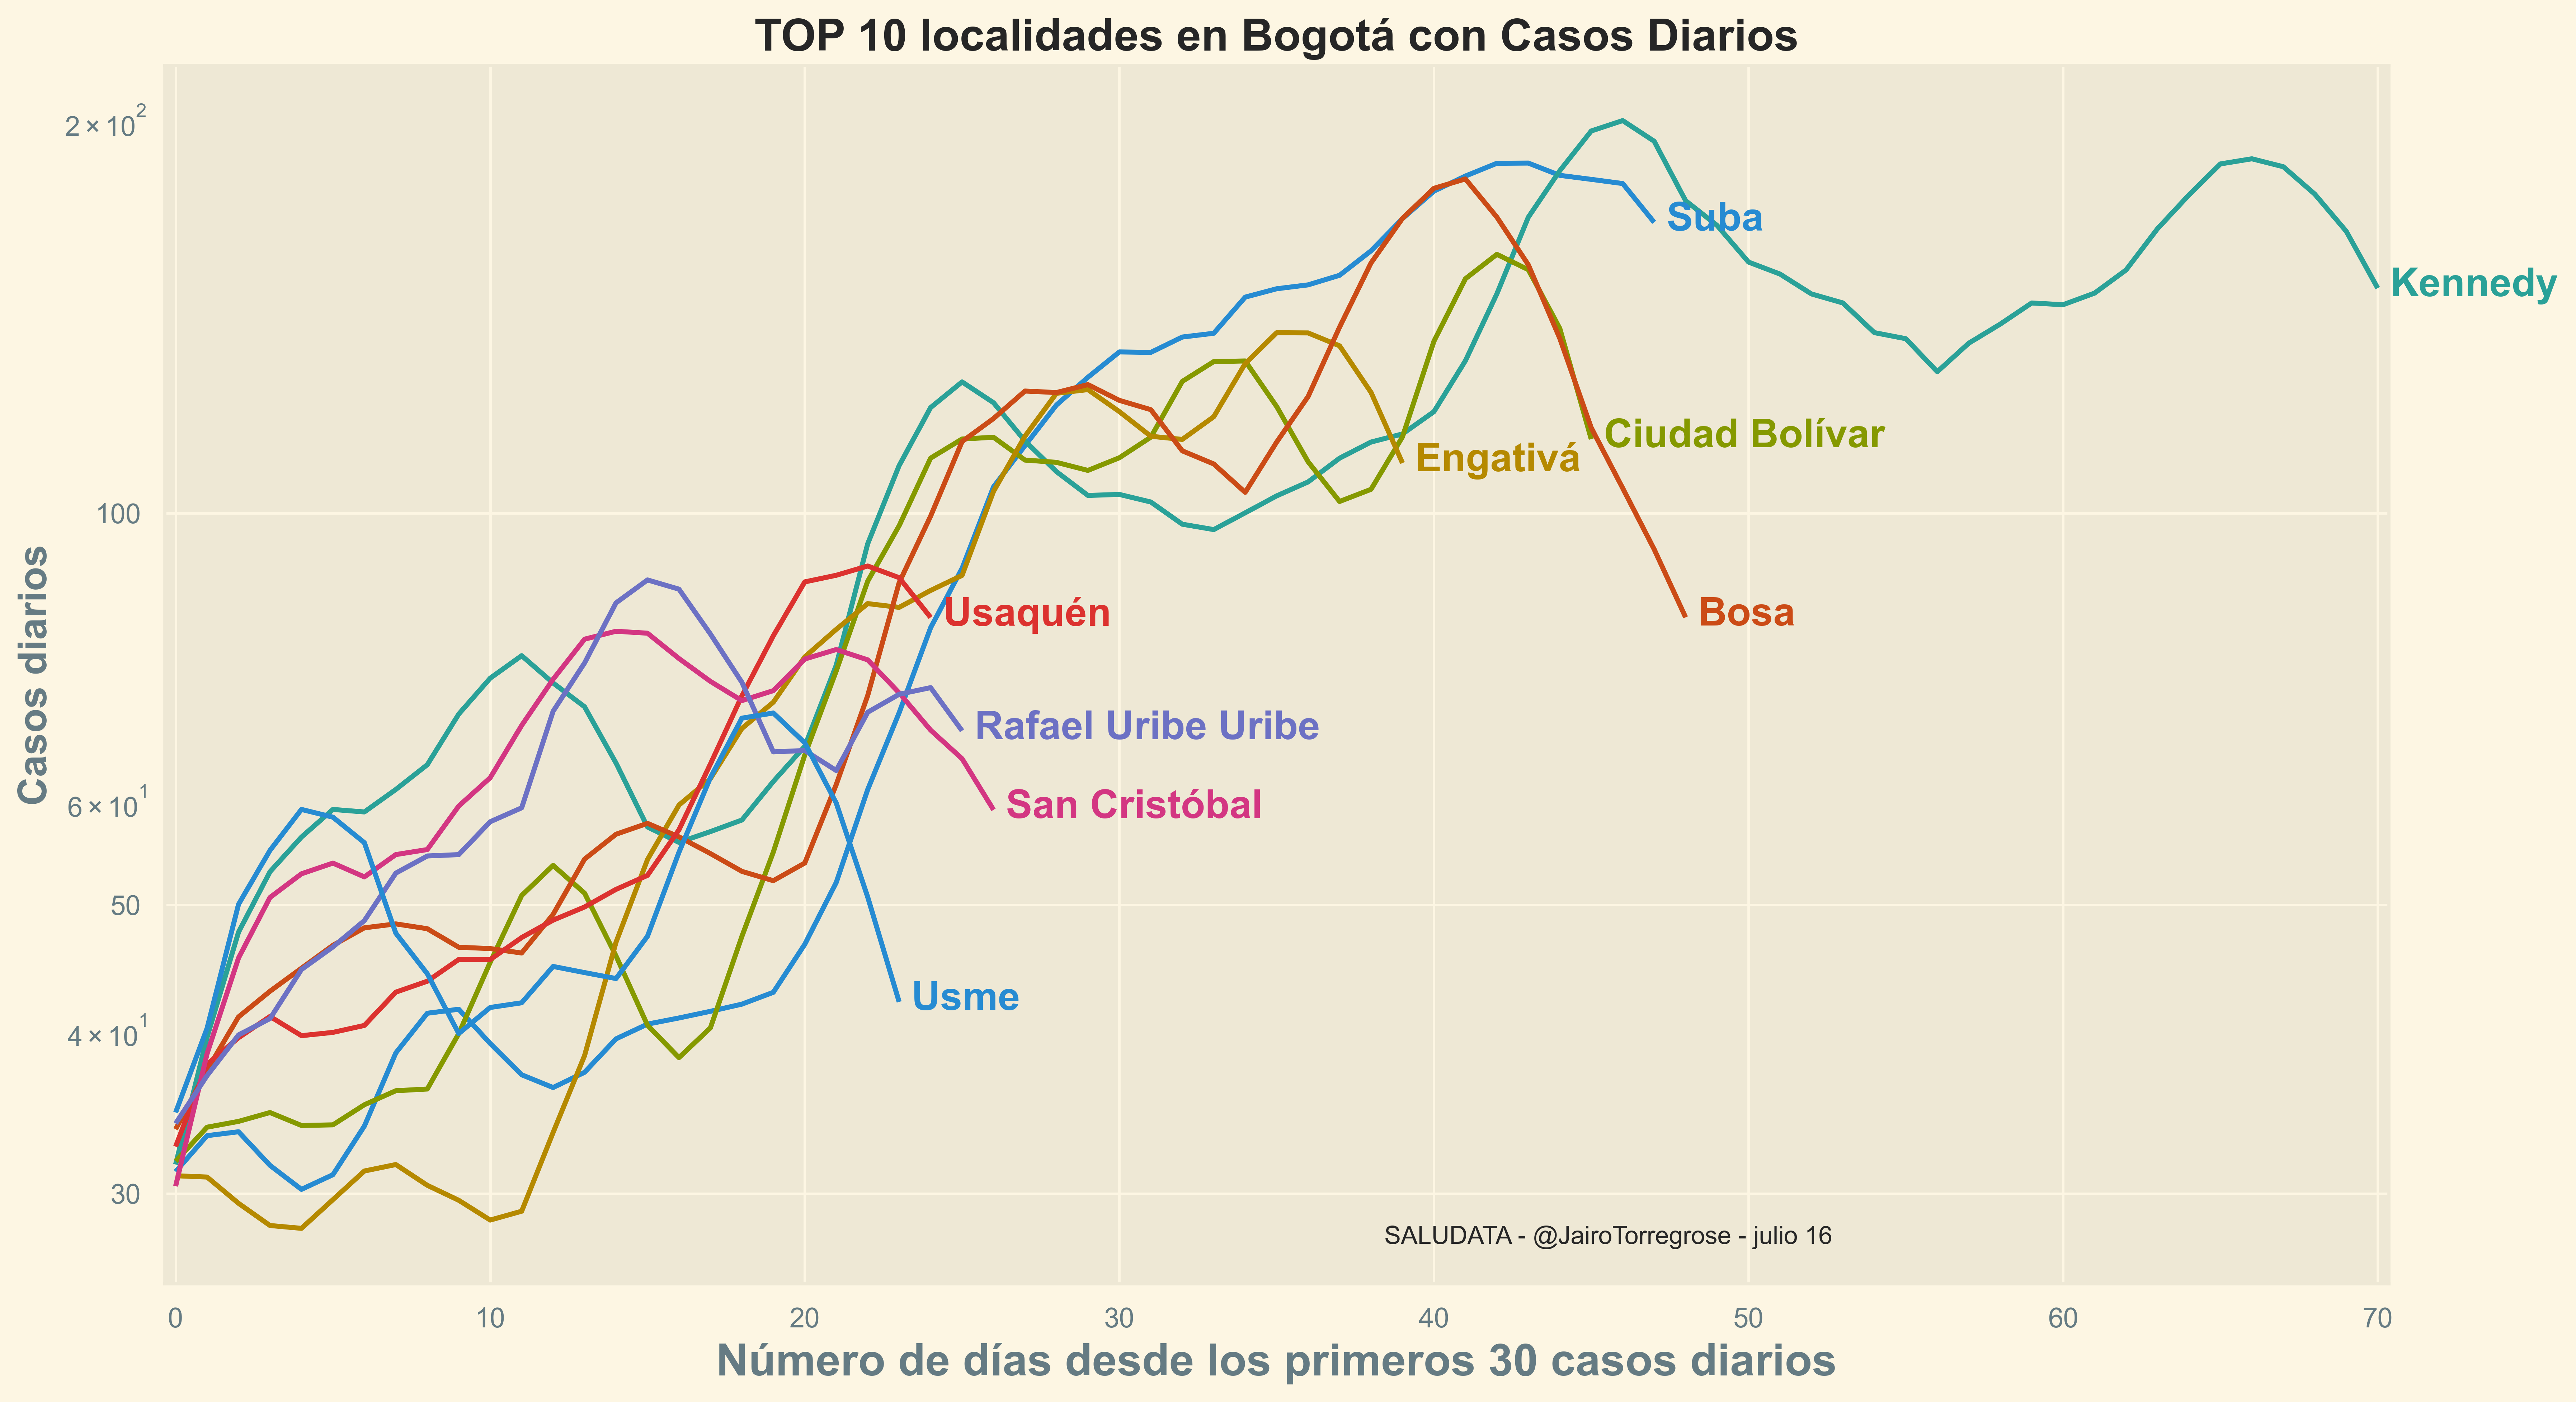

In [12]:
graficar(df_bog_casos, titulo_diarios, xlabel_diarios, ylabel_diarios , texto_bog)